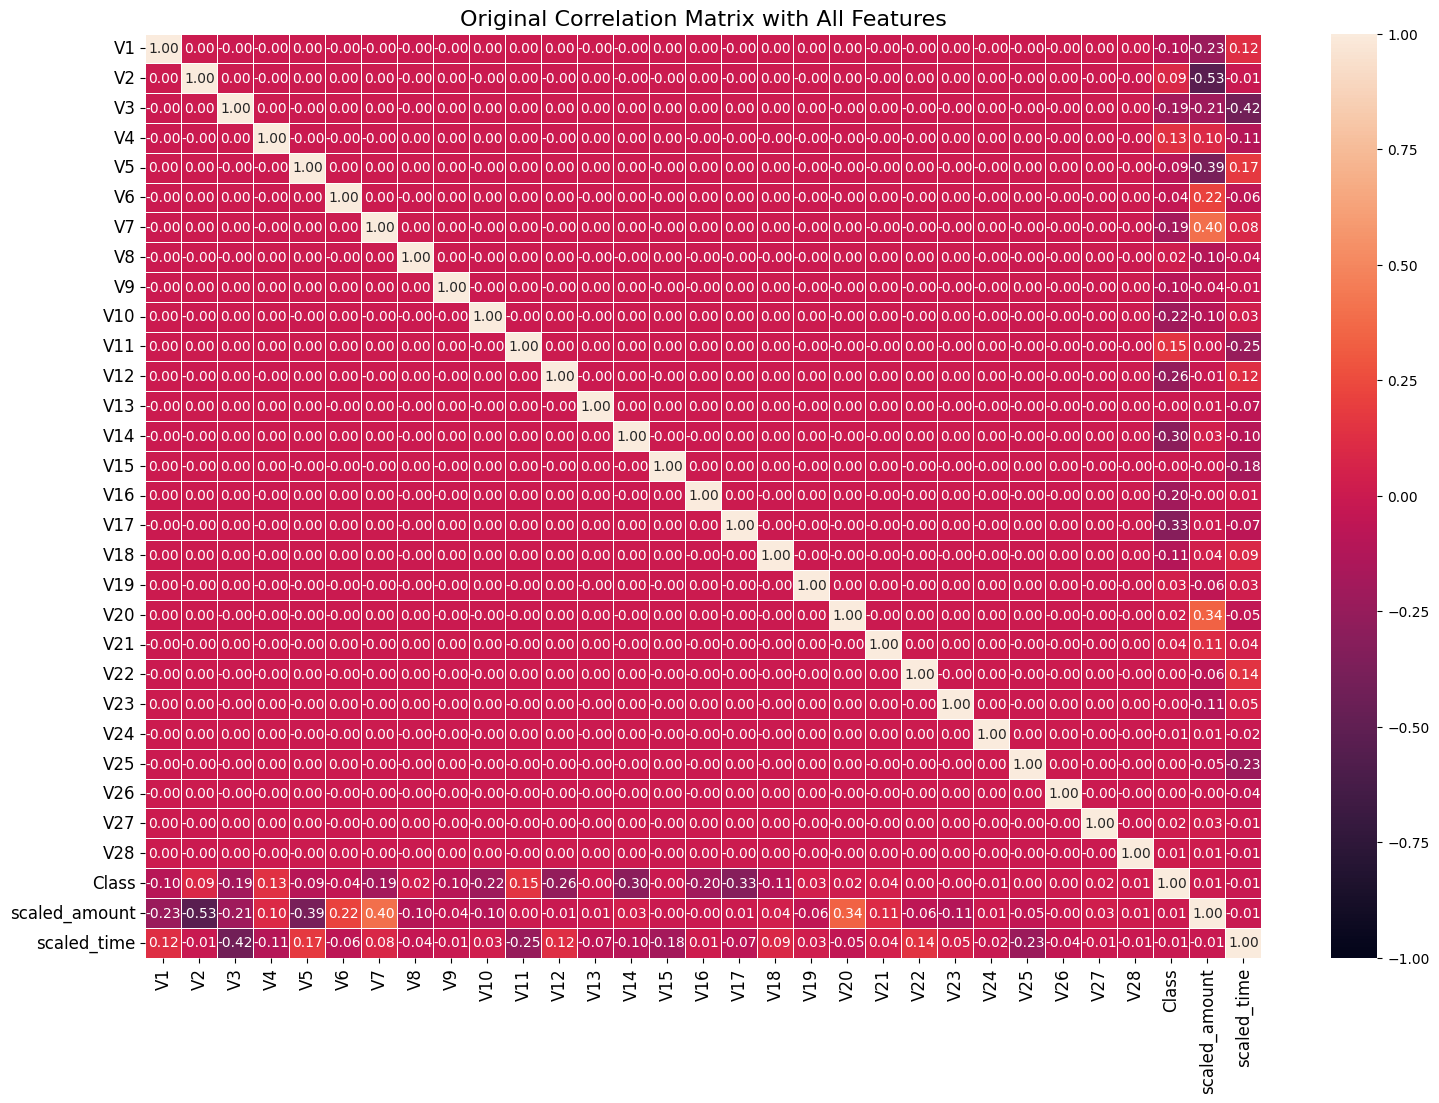

Significant Features (Correlation > 0.1):
 ['V1', 'V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

Removed Insignificant Features (Correlation <= 0.1):
 ['V2', 'V5', 'V6', 'V8', 'V9', 'V13', 'V15', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount', 'scaled_time']
Resampling with SMOTE...


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Resampled dataset shape: (568630, 11)
Training the ensemble model...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2352           0.1508            1.16m
         2           1.1113           0.1248           49.92s
         3           1.0082           0.1027           40.34s
         4           0.9190           0.0902           31.98s
         5           0.8440           0.0720           25.28s
         6           0.7796           0.0661           20.20s
         7           0.7234           0.0575           14.66s
         8           0.6750           0.0495            9.53s
         9           0.6316           0.0445            4.78s
        10           0.5935           0.0377            0.00s

Model training time: 80.71 seconds
Making predictions...
Prediction time: 0.16 seconds
Model Accuracy: 0.9708

Confusion Matrix:
 [[56343   407]
 [ 2917 54059]]

Classification Report:
               precision    recall  f1-score   support

      

In [ ]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('creditcard.csv')

# Feature scaling: Scaling 'Amount' and 'Time'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop the original columns after scaling
df = df.drop(['Amount', 'Time'], axis=1)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the original correlation matrix with all features using the 'rocket' colormap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5, annot_kws={"size": 10})
plt.title('Original Correlation Matrix with All Features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Define a threshold for selecting significant variables
significant_corr_threshold = 0.1
correlation_with_target = correlation_matrix['Class'].drop('Class')

# Identify significant features based on the threshold
significant_features = correlation_with_target[abs(correlation_with_target) > significant_corr_threshold].index.tolist()
insignificant_features = correlation_with_target[abs(correlation_with_target) <= significant_corr_threshold].index.tolist()

print("Significant Features (Correlation > 0.1):\n", significant_features)
print("\nRemoved Insignificant Features (Correlation <= 0.1):\n", insignificant_features)

# Keep only significant features
df_significant = df[significant_features + ['Class']]

# Define X (features) and y (target)
X = df_significant.drop('Class', axis=1)
y = df_significant['Class']

# Check for missing values in the target variable
if y.isnull().any():
    print("Warning: Missing values found in the target variable. Handling them...")
    df_significant = df_significant.dropna(subset=['Class'])
    X = df_significant.drop('Class', axis=1)
    y = df_significant['Class']

# Handle the imbalanced dataset using SMOTE
print("Resampling with SMOTE...")
sm = SMOTE(random_state=42, n_jobs=-1)
X_resampled, y_resampled = sm.fit_resample(X, y)

print("Resampled dataset shape:", X_resampled.shape)  # Check the shape

# Optionally work with a smaller subset for testing
# X_resampled = X_resampled[:10000]
# y_resampled = y_resampled[:10000]

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Training time tracking
start_time = time.time()

print("Training the ensemble model...")
rf_model = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1)  # Reduced estimators and max depth
gb_model = GradientBoostingClassifier(n_estimators=10, subsample=0.9, random_state=42, verbose=1)  # Reduced estimators and added subsampling

ensemble_model = VotingClassifier(estimators=[
    ('random_forest', rf_model),
    ('gradient_boosting', gb_model)
], voting='soft')

ensemble_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"\nModel training time: {training_time:.2f} seconds")

# Make predictions on the test set
print("Making predictions...")
start_time = time.time()
y_pred = ensemble_model.predict(X_test)
prediction_time = time.time() - start_time
print(f"Prediction time: {prediction_time:.2f} seconds")

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Define new data for prediction
new_data_non_fraudulent = pd.DataFrame({
    'V1': [-1.359807],  'V3': [2.536346], 'V4': [1.378155], 'V7': [0.239599], 'V10': [0.090794],
    'V11': [-0.5516],  'V12': [0.415798],  'V14': [0.069083],  'V16': [0.237609],  'V17': [-0.377869],
    'V18': [0.505056], 'scaled_amount': scaler.transform([[123.45]]).flatten(), 'scaled_time': scaler.transform([[10000]]).flatten()
})

new_data_fraudulent = pd.DataFrame({
    'V1': [1.76321],  'V3': [1.8953], 'V4': [2.564], 'V7': [-1.8954], 'V10': [0.58294],
    'V11': [-1.87654],  'V12': [1.543],  'V14': [-0.56423],  'V16': [0.76435],  'V17': [-1.564],
    'V18': [0.6573], 'scaled_amount': scaler.transform([[800]]).flatten(), 'scaled_time': scaler.transform([[150000]]).flatten()
})

# Drop unnecessary columns for prediction
new_data_fraudulent = new_data_fraudulent[significant_features]
new_data_non_fraudulent = new_data_non_fraudulent[significant_features]

# Predict for new transactions
print("\nPrediction for Fraudulent Transaction (Ensemble):")
prediction_fraudulent = ensemble_model.predict(new_data_fraudulent)
print("Prediction:", "Fraudulent" if prediction_fraudulent[0] == 1 else "Not Fraudulent")

print("\nPrediction for Non-Fraudulent Transaction (Ensemble):")
prediction_non_fraudulent = ensemble_model.predict(new_data_non_fraudulent)
print("Prediction:", "Fraudulent" if prediction_non_fraudulent[0] == 1 else "Not Fraudulent")


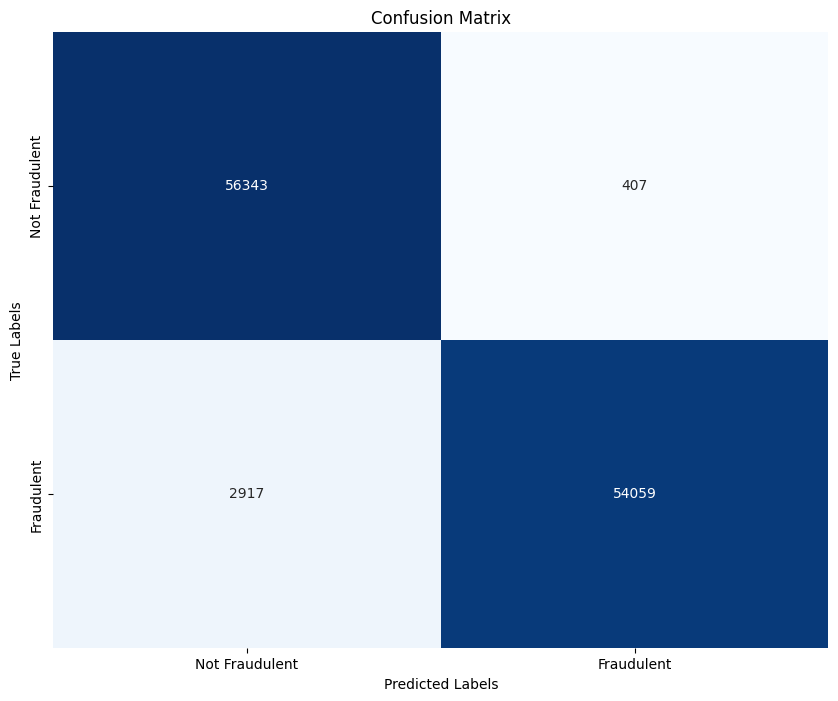

In [ ]:
import numpy as np

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraudulent', 'Fraudulent'],
            yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2352           0.1508           35.40s
         2           1.1113           0.1248           31.38s
         3           1.0082           0.1027           29.82s
         4           0.9190           0.0902           25.27s
         5           0.8440           0.0720           20.87s
         6           0.7796           0.0661           17.10s
         7           0.7234           0.0575           12.78s
         8           0.6750           0.0495            8.44s
         9           0.6316           0.0445            4.22s
        10           0.5935           0.0377            0.00s


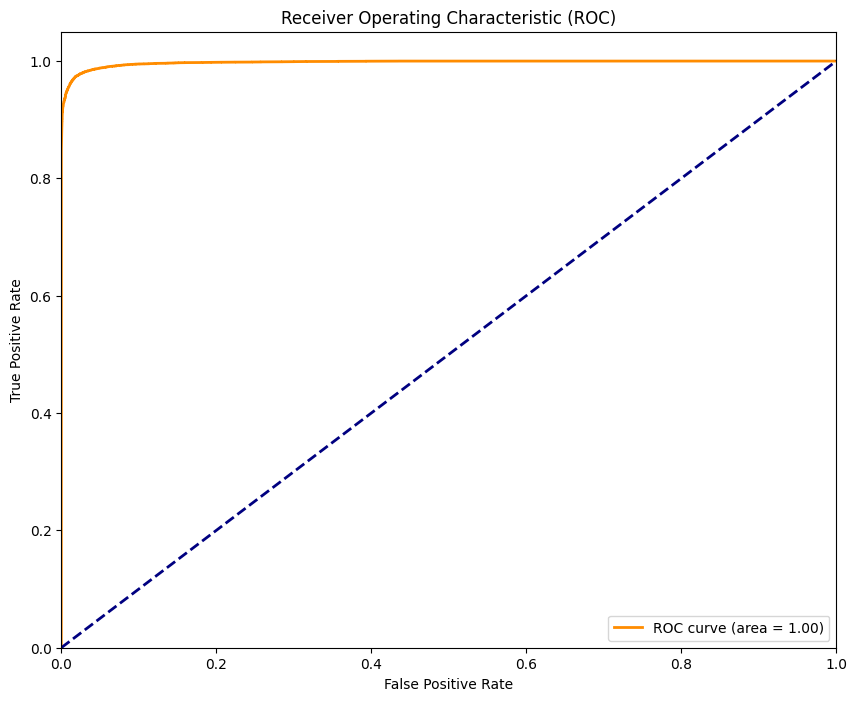

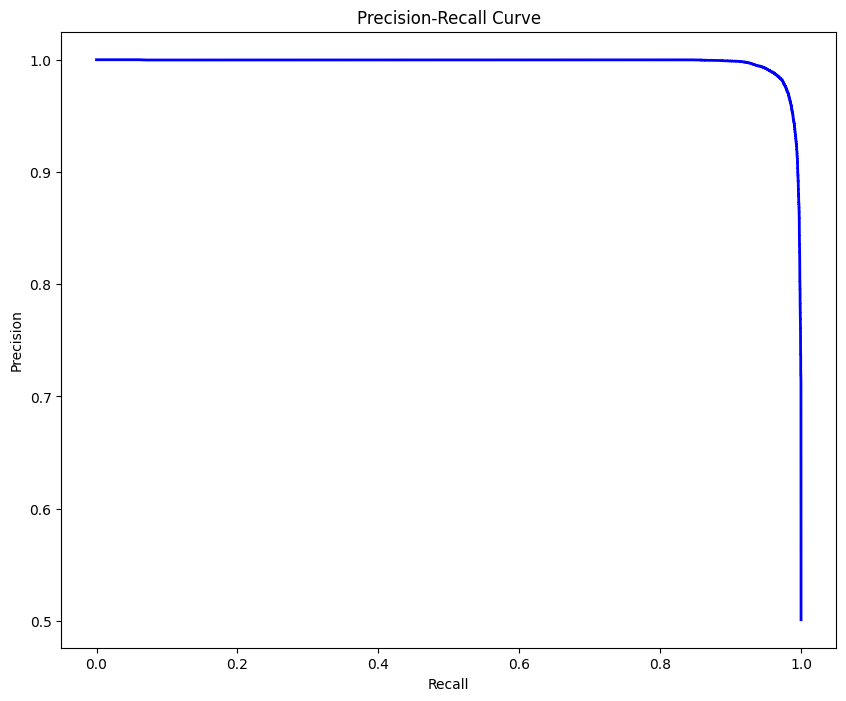

F1 Score: 0.9702


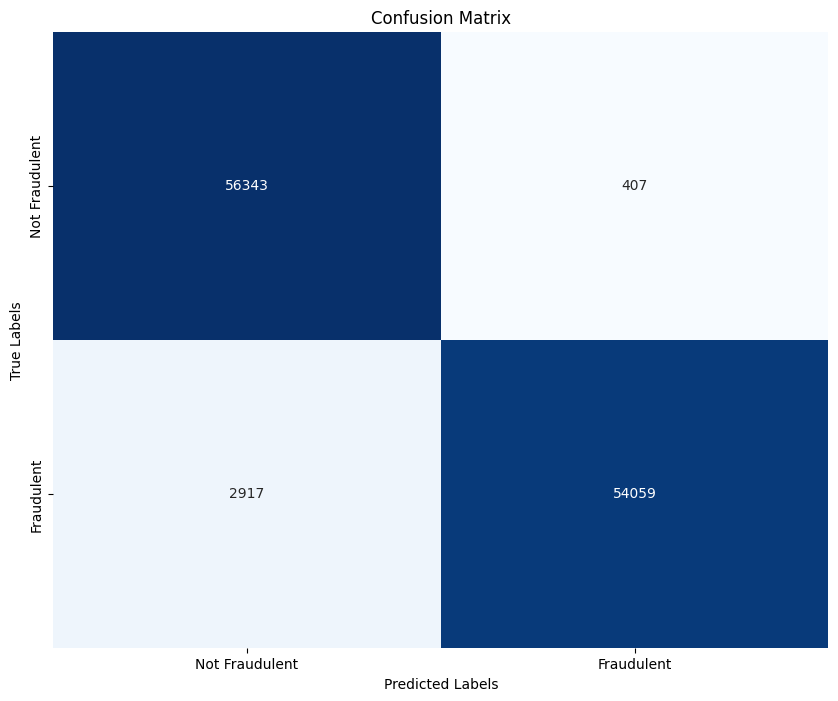

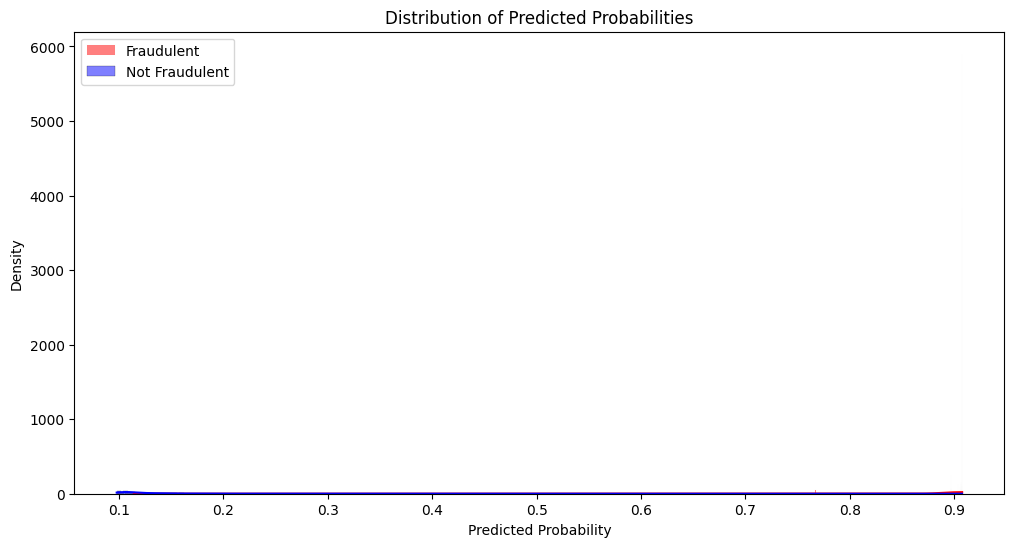

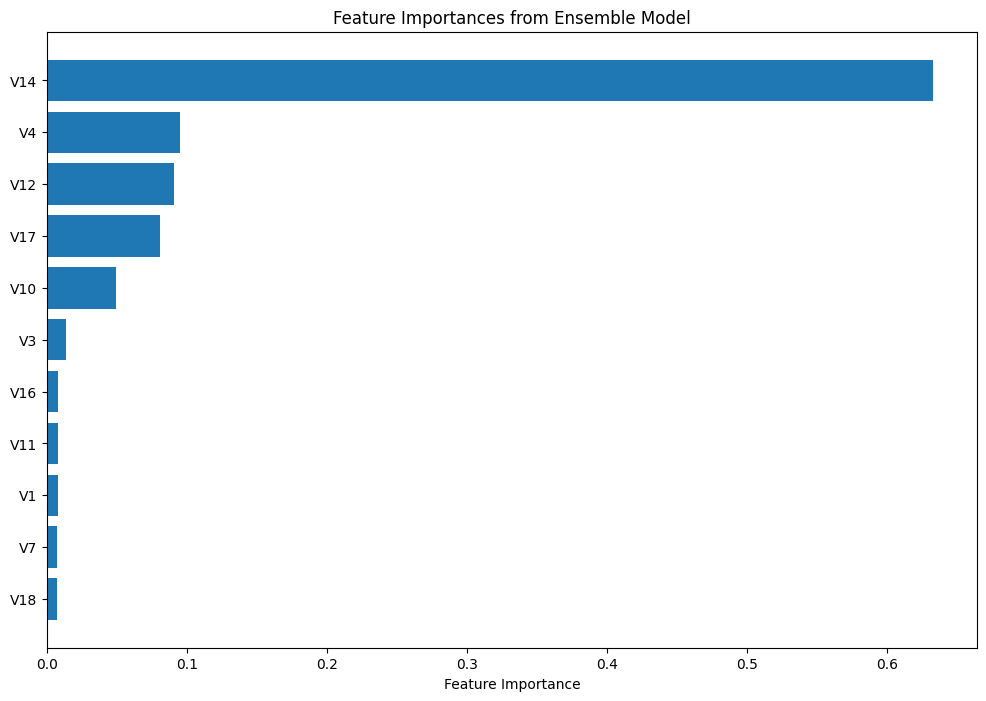

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import f1_score


import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('creditcard.csv')

# Feature scaling: Scaling 'Amount' and 'Time'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop the original columns after scaling
df = df.drop(['Amount', 'Time'], axis=1)

# Compute the correlation matrix
correlation_matrix = df.corr()


# Define a threshold for selecting significant variables
significant_corr_threshold = 0.1
correlation_with_target = correlation_matrix['Class'].drop('Class')

# Identify significant features based on the threshold
significant_features = correlation_with_target[abs(correlation_with_target) > significant_corr_threshold].index.tolist()
insignificant_features = correlation_with_target[abs(correlation_with_target) <= significant_corr_threshold].index.tolist()



# Keep only significant features
df_significant = df[significant_features + ['Class']]

# Define X (features) and y (target)
X = df_significant.drop('Class', axis=1)
y = df_significant['Class']

# Check for missing values in the target variable
if y.isnull().any():
    print("Warning: Missing values found in the target variable. Handling them...")
    df_significant = df_significant.dropna(subset=['Class'])
    X = df_significant.drop('Class', axis=1)
    y = df_significant['Class']

# Handle the imbalanced dataset using SMOTE

sm = SMOTE(random_state=42, n_jobs=-1)
X_resampled, y_resampled = sm.fit_resample(X, y)
 # Check the shape

# Optionally work with a smaller subset for testing
# X_resampled = X_resampled[:10000]
# y_resampled = y_resampled[:10000]

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Training time tracking
start_time = time.time()


rf_model = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1)  # Reduced estimators and max depth
gb_model = GradientBoostingClassifier(n_estimators=10, subsample=0.9, random_state=42, verbose=1)  # Reduced estimators and added subsampling

ensemble_model = VotingClassifier(estimators=[
    ('random_forest', rf_model),
    ('gradient_boosting', gb_model)
], voting='soft')

ensemble_model.fit(X_train, y_train)

training_time = time.time() - start_time
# Make predictions on the test set

start_time = time.time()
y_pred = ensemble_model.predict(X_test)
prediction_time = time.time() - start_time


# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)


# Define new data for prediction
new_data_non_fraudulent = pd.DataFrame({
    'V1': [-1.359807],  'V3': [2.536346], 'V4': [1.378155], 'V7': [0.239599], 'V10': [0.090794],
    'V11': [-0.5516],  'V12': [0.415798],  'V14': [0.069083],  'V16': [0.237609],  'V17': [-0.377869],
    'V18': [0.505056], 'scaled_amount': scaler.transform([[123.45]]).flatten(), 'scaled_time': scaler.transform([[10000]]).flatten()
})

new_data_fraudulent = pd.DataFrame({
    'V1': [1.76321],  'V3': [1.8953], 'V4': [2.564], 'V7': [-1.8954], 'V10': [0.58294],
    'V11': [-1.87654],  'V12': [1.543],  'V14': [-0.56423],  'V16': [0.76435],  'V17': [-1.564],
    'V18': [0.6573], 'scaled_amount': scaler.transform([[800]]).flatten(), 'scaled_time': scaler.transform([[150000]]).flatten()
})

# Drop unnecessary columns for prediction
new_data_fraudulent = new_data_fraudulent[significant_features]
new_data_non_fraudulent = new_data_non_fraudulent[significant_features]

# Predict for new transactions

prediction_fraudulent = ensemble_model.predict(new_data_fraudulent)



prediction_non_fraudulent = ensemble_model.predict(new_data_non_fraudulent)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import numpy as np

# Ensure that the ensemble model is fitted
if hasattr(ensemble_model, "estimators_"):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, ensemble_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, ensemble_model.predict_proba(X_test)[:, 1])

    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # Compute F1 Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Fraudulent', 'Fraudulent'],
                yticklabels=['Not Fraudulent', 'Fraudulent'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Distribution of Predicted Probabilities
    probabilities = ensemble_model.predict_proba(X_test)[:, 1]

    plt.figure(figsize=(12, 6))
    sns.histplot(probabilities[y_test == 1], kde=True, color='red', label='Fraudulent', stat='density')
    sns.histplot(probabilities[y_test == 0], kde=True, color='blue', label='Not Fraudulent', stat='density')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Distribution of Predicted Probabilities')
    plt.legend()
    plt.show()

    # Feature Importances from the ensemble model
    feature_importances = np.mean([est.feature_importances_ for est in ensemble_model.estimators_], axis=0)
    feature_names = X.columns
    sorted_idx = np.argsort(feature_importances)

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_names)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(feature_names)), np.array(feature_names)[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances from Ensemble Model')
    plt.show()

else:
    print("Ensemble model is not fitted. Please fit the model first.")


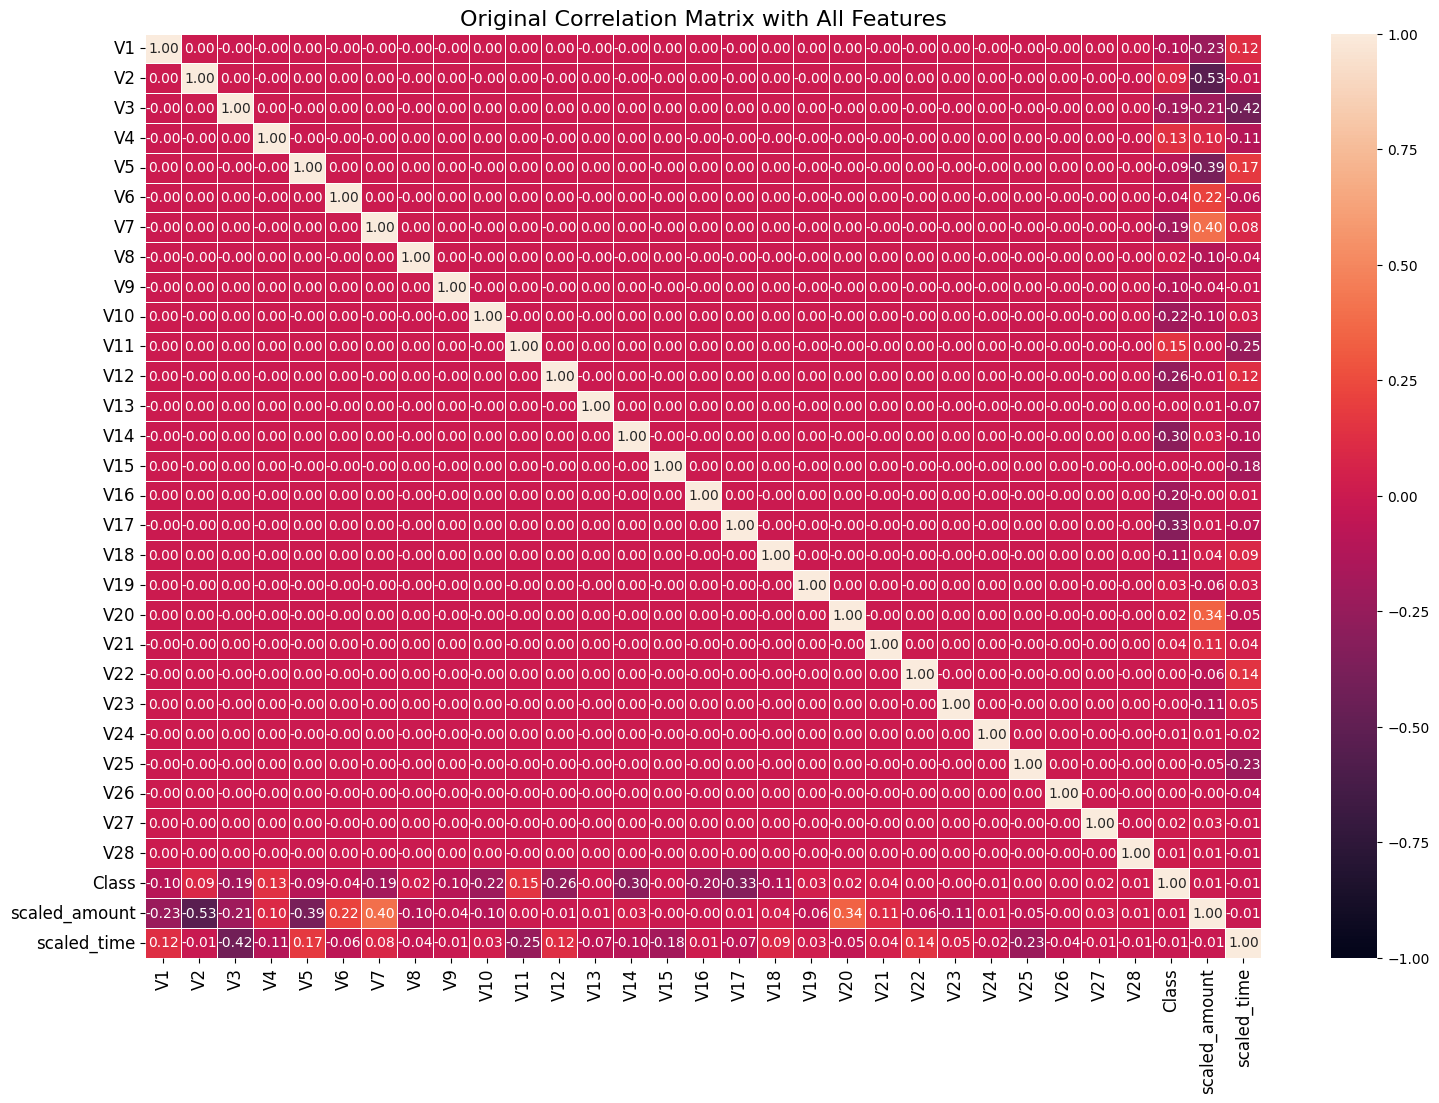

Significant Features (Correlation > 0.1):
 ['V1', 'V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

Removed Insignificant Features (Correlation <= 0.1):
 ['V2', 'V5', 'V6', 'V8', 'V9', 'V13', 'V15', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount', 'scaled_time']
Resampling with SMOTE...
Resampled dataset shape: (568630, 11)


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Training the ensemble model...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2352           0.1508           31.76s
         2           1.1113           0.1248           29.41s
         3           1.0082           0.1027           24.45s
         4           0.9190           0.0902           20.46s
         5           0.8440           0.0720           17.05s
         6           0.7796           0.0661           14.35s
         7           0.7234           0.0575           10.56s
         8           0.6750           0.0495            6.93s
         9           0.6316           0.0445            3.45s
        10           0.5935           0.0377            0.00s

Model training time: 52.20 seconds
Making predictions...
Prediction time: 0.11 seconds
Model Accuracy: 0.9708

Confusion Matrix:
 [[56343   407]
 [ 2917 54059]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97 

In [3]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('creditcard.csv')

# Feature scaling: Scaling 'Amount' and 'Time'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop the original columns after scaling
df = df.drop(['Amount', 'Time'], axis=1)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the original correlation matrix with all features using the 'rocket' colormap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5, annot_kws={"size": 10})
plt.title('Original Correlation Matrix with All Features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Define a threshold for selecting significant variables
significant_corr_threshold = 0.1
correlation_with_target = correlation_matrix['Class'].drop('Class')

# Identify significant features based on the threshold
significant_features = correlation_with_target[abs(correlation_with_target) > significant_corr_threshold].index.tolist()
insignificant_features = correlation_with_target[abs(correlation_with_target) <= significant_corr_threshold].index.tolist()

print("Significant Features (Correlation > 0.1):\n", significant_features)
print("\nRemoved Insignificant Features (Correlation <= 0.1):\n", insignificant_features)

# Keep only significant features
df_significant = df[significant_features + ['Class']]

# Define X (features) and y (target)
X = df_significant.drop('Class', axis=1)
y = df_significant['Class']

# Check for missing values in the target variable
if y.isnull().any():
    print("Warning: Missing values found in the target variable. Handling them...")
    df_significant = df_significant.dropna(subset=['Class'])
    X = df_significant.drop('Class', axis=1)
    y = df_significant['Class']

# Handle the imbalanced dataset using SMOTE
print("Resampling with SMOTE...")
sm = SMOTE(random_state=42, n_jobs=-1)
X_resampled, y_resampled = sm.fit_resample(X, y)

print("Resampled dataset shape:", X_resampled.shape)  # Check the shape

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Training time tracking
start_time = time.time()

print("Training the ensemble model...")
rf_model = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1)  # Reduced estimators and max depth
gb_model = GradientBoostingClassifier(n_estimators=10, subsample=0.9, random_state=42, verbose=1)  # Reduced estimators and added subsampling

ensemble_model = VotingClassifier(estimators=[
    ('random_forest', rf_model),
    ('gradient_boosting', gb_model)
], voting='soft')

ensemble_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"\nModel training time: {training_time:.2f} seconds")

# Make predictions on the test set
print("Making predictions...")
start_time = time.time()
y_pred = ensemble_model.predict(X_test)
prediction_time = time.time() - start_time
print(f"Prediction time: {prediction_time:.2f} seconds")

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Define new data for prediction using only significant features
new_data_non_fraudulent = pd.DataFrame({
    'V1': [-1.359807], 'V3': [2.536346], 'V4': [1.378155], 'V7': [0.239599], 'V10': [0.090794],
    'V11': [-0.5516], 'V12': [0.415798], 'V14': [0.069083], 'V16': [0.237609], 'V17': [-0.377869],
    'V18': [0.505056], 'scaled_amount': scaler.transform([[123.45]]).flatten(), 'scaled_time': scaler.transform([[10000]]).flatten()
})

new_data_fraudulent = pd.DataFrame({
    'V1': [1.76321], 'V3': [1.8953], 'V4': [2.564], 'V7': [-1.8954], 'V10': [0.58294],
    'V11': [-1.87654], 'V12': [1.543], 'V14': [-0.56423], 'V16': [0.76435], 'V17': [-1.564],
    'V18': [0.6573], 'scaled_amount': scaler.transform([[800]]).flatten(), 'scaled_time': scaler.transform([[150000]]).flatten()
})

# Select only significant features for the prediction
new_data_fraudulent_significant = new_data_fraudulent[significant_features]
new_data_non_fraudulent_significant = new_data_non_fraudulent[significant_features]

# Predict for new transactions using significant features
print("\nPrediction for Fraudulent Transaction (Ensemble with Significant Features):")
start_time_significant = time.time()
prediction_fraudulent_significant = ensemble_model.predict(new_data_fraudulent_significant)
prediction_time_significant = time.time() - start_time_significant
print("Prediction:", "Fraudulent" if prediction_fraudulent_significant[0] == 1 else "Not Fraudulent")
print(f"Prediction time (Significant Features): {prediction_time_significant:.4f} seconds")

print("\nPrediction for Non-Fraudulent Transaction (Ensemble with Significant Features):")
start_time_significant_non = time.time()
prediction_non_fraudulent_significant = ensemble_model.predict(new_data_non_fraudulent_significant)
prediction_time_significant_non = time.time() - start_time_significant_non
print("Prediction:", "Fraudulent" if prediction_non_fraudulent_significant[0] == 1 else "Not Fraudulent")
print(f"Prediction time (Significant Features): {prediction_time_significant_non:.4f} seconds")
